In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Display settings for notebooks
%matplotlib inline
plt.style.use('ggplot')  # alternative native style



# Increase display width for nicer table viewing
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

In [9]:
# Load the precomputed features CSV
# This file should contain columns: date, open, high, low, close, adjclose, volume,
# Return, MA20, MA50, Volatility, RSI, and (optionally) Target


df = pd.read_csv('data/cac40_features.csv')


# Ensure date parsing and sorting
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)


# Quick peek
print('Rows, columns:', df.shape)
df.head()

Rows, columns: (4011, 14)


,symbol,date,open,high,low,close,volume,adjclose,Return,MA20,MA50,Volatility,RSI,Target
0,^FCHI,2010-03-12,3933.969971,3956.419922,3919.070068,3927.399902,114568600.0,3927.399902,-0.000395,3791.305493,3820.455796,0.010680,67.274531,0
1,^FCHI,2010-03-15,3921.000000,3925.860107,3889.129883,3890.909912,94752800.0,3890.909912,-0.009291,3805.389990,3817.994595,0.011110,69.113996,1
2,^FCHI,2010-03-16,3914.389893,3951.469971,3910.810059,3938.949951,108838800.0,3938.949951,0.012347,3818.885486,3816.515396,0.010893,71.453827,1
3,^FCHI,2010-03-17,3954.300049,3967.510010,3943.169922,3957.889893,124548900.0,3957.889893,0.004808,3830.519482,3815.319795,0.010547,84.144428,0
4,^FCHI,2010-03-18,3936.939941,3964.780029,3923.260010,3938.179932,125638800.0,3938.179932,-0.004980,3840.036975,3813.587393,0.010671,77.565718,0


In [11]:
# General information
print(df.info())


# Summary statistics for numeric columns
df.describe().T


# Check for missing values
missing = df.isna().sum()
print('\nMissing values per column:')
print(missing[missing>0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4011 entries, 0 to 4010
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   symbol      4011 non-null   object        
 1   date        4011 non-null   datetime64[ns]
 2   open        4011 non-null   float64       
 3   high        4011 non-null   float64       
 4   low         4011 non-null   float64       
 5   close       4011 non-null   float64       
 6   volume      4011 non-null   float64       
 7   adjclose    4011 non-null   float64       
 8   Return      4011 non-null   float64       
 9   MA20        4011 non-null   float64       
 10  MA50        4011 non-null   float64       
 11  Volatility  4011 non-null   float64       
 12  RSI         4011 non-null   float64       
 13  Target      4011 non-null   int64         
dtypes: datetime64[ns](1), float64(11), int64(1), object(1)
memory usage: 438.8+ KB
None

Missing values per column:
Series([

Target value counts:
Target
1    2103
0    1908
Name: count, dtype: int64

Target proportions:
Target
1    0.524308
0    0.475692
Name: proportion, dtype: float64


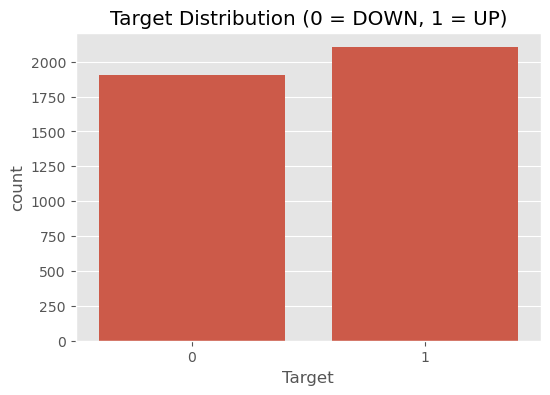

In [15]:
# If Target not present, compute it for the notebook view
if 'Target' not in df.columns:
    df['Target'] = (df['close'].shift(-1) > df['close']).astype(int)
    df = df.dropna().reset_index(drop=True)


# Class balance
print('Target value counts:')
print(df['Target'].value_counts(normalize=False))
print('\nTarget proportions:')
print(df['Target'].value_counts(normalize=True))


# Plot target distribution
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Target', data=df)
ax.set_title('Target Distribution (0 = DOWN, 1 = UP)')
plt.show()

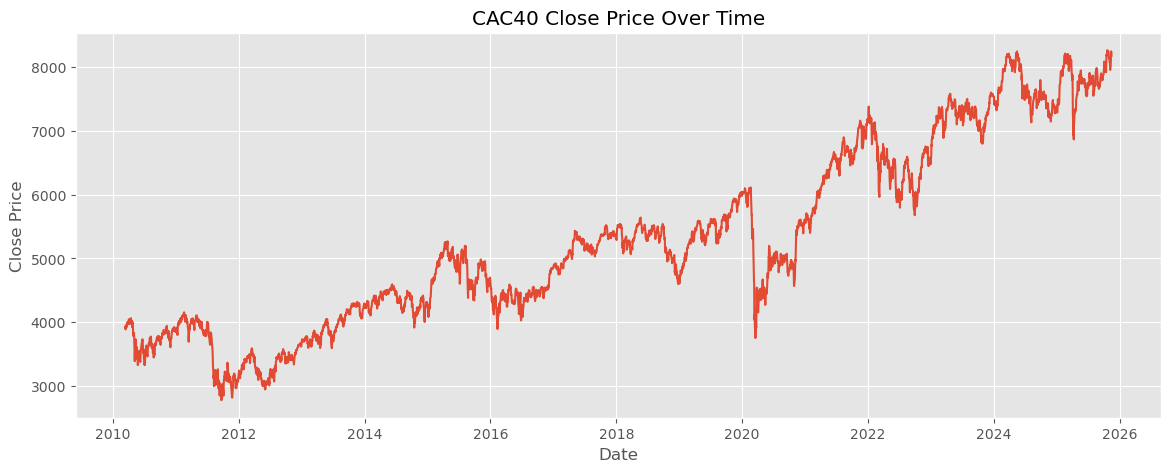

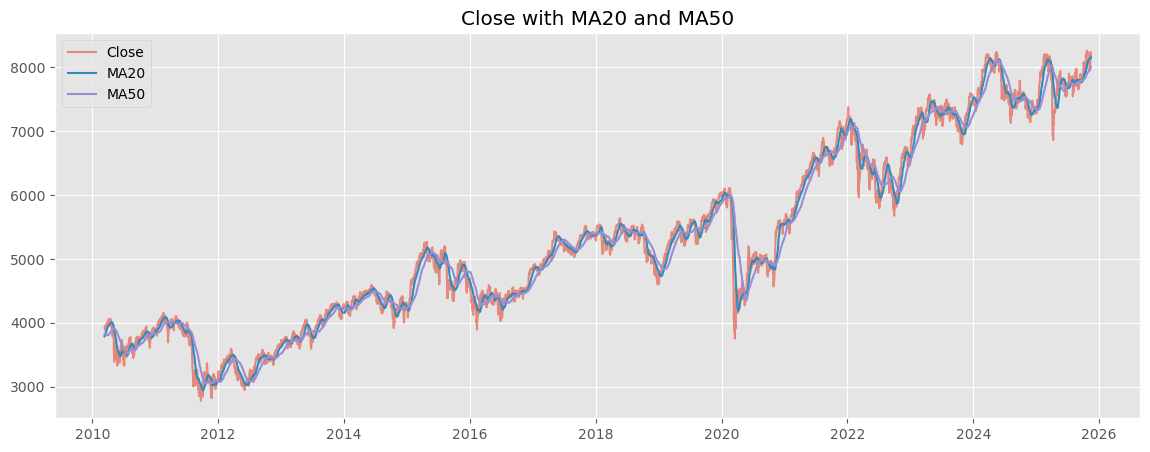

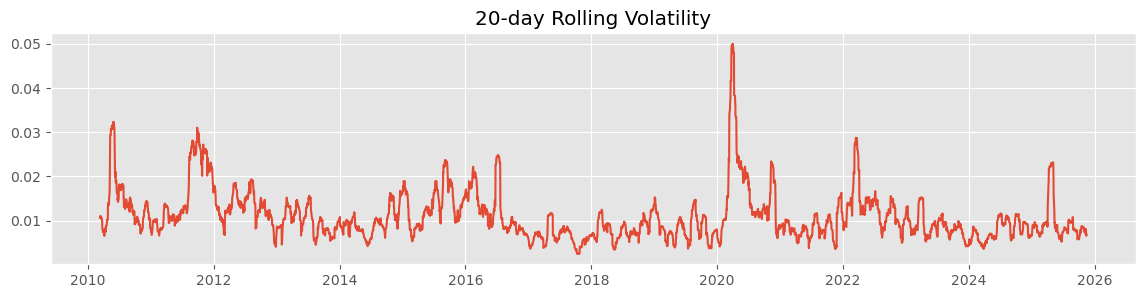

In [23]:
# Plot close price over time
plt.figure(figsize=(14,5))
plt.plot(df['date'], df['close'])
plt.title('CAC40 Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


# Plot MA20 and MA50 overlayed on close
plt.figure(figsize=(14,5))
plt.plot(df['date'], df['close'], label='Close', alpha=0.6)
if 'MA20' in df.columns:
    plt.plot(df['date'], df['MA20'], label='MA20')
if 'MA50' in df.columns:
    plt.plot(df['date'], df['MA50'], label='MA50')
    plt.title('Close with MA20 and MA50')
    plt.legend()
    plt.show()


# Rolling volatility (20-day) plot
if 'Volatility' in df.columns:
    plt.figure(figsize=(14,3))
    plt.plot(df['date'], df['Volatility'])
    plt.title('20-day Rolling Volatility')
    plt.show()

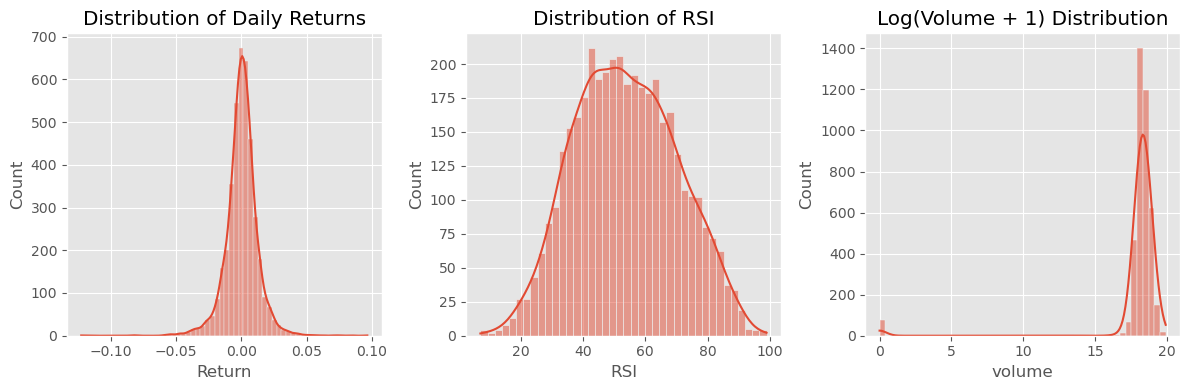

In [25]:
# Histogram + KDE of returns, RSI, Volume
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(df['Return'], bins=60, kde=True)
plt.title('Distribution of Daily Returns')


plt.subplot(1,3,2)
sns.histplot(df['RSI'], bins=40, kde=True)
plt.title('Distribution of RSI')


plt.subplot(1,3,3)
# Volume typically skewed: use log scale for plotting
sns.histplot(np.log1p(df['volume']), bins=50, kde=True)
plt.title('Log(Volume + 1) Distribution')
plt.tight_layout()
plt.show()

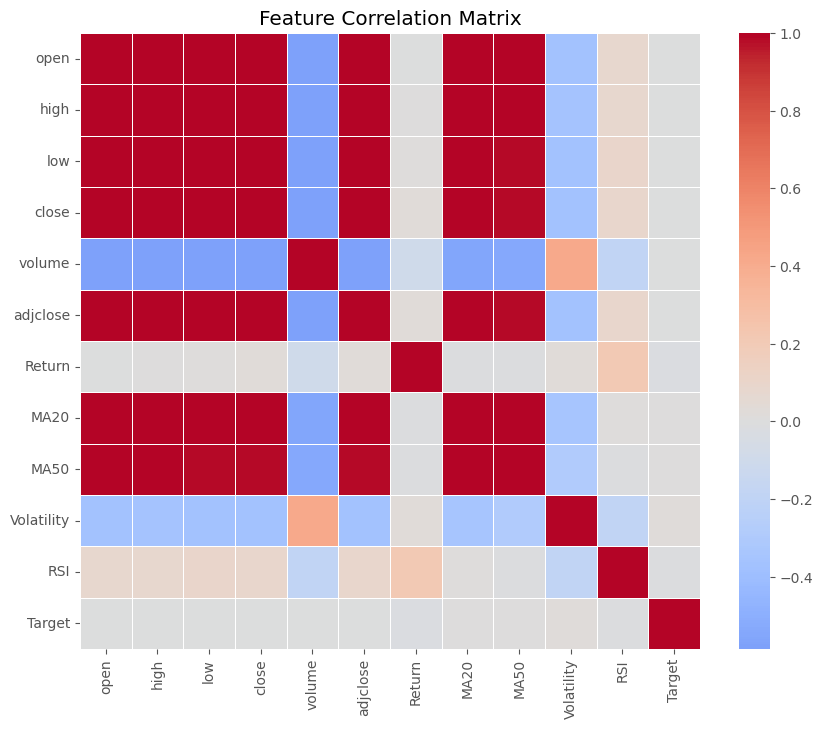


Top absolute correlations with Target:
Target        1.000000
Return        0.021299
Volatility    0.016229
RSI           0.013045
MA50          0.006137
MA20          0.003868
open          0.002411
high          0.002321
close         0.002266
adjclose      0.002266
Name: Target, dtype: float64


In [27]:
# Keep only numeric columns for correlation
numeric = df.select_dtypes(include=['float64', 'int64'])


# Correlation matrix
corr = numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.show()


# Print top correlations with the target
if 'Target' in corr.columns:
    print('\nTop absolute correlations with Target:')
    print(corr['Target'].abs().sort_values(ascending=False).head(10))

<Figure size 1000x400 with 0 Axes>

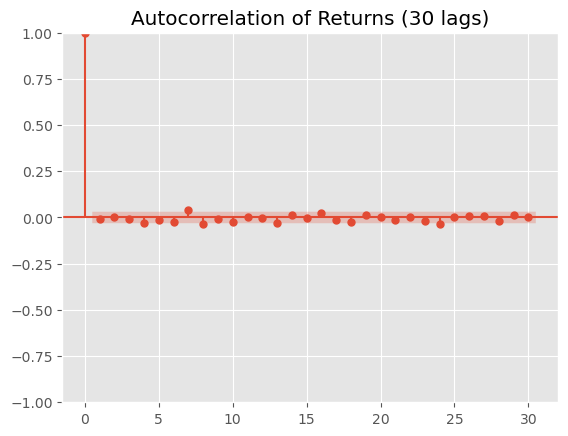

<Figure size 1000x400 with 0 Axes>

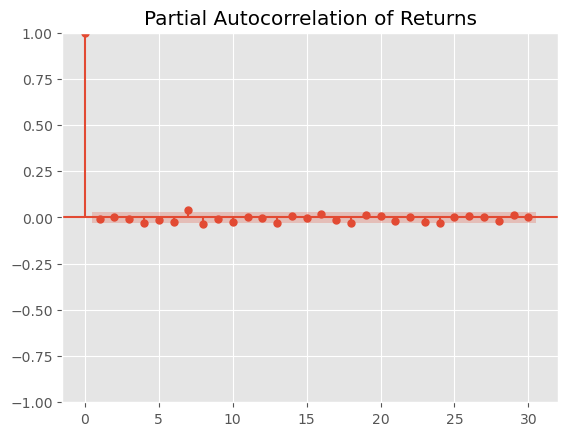

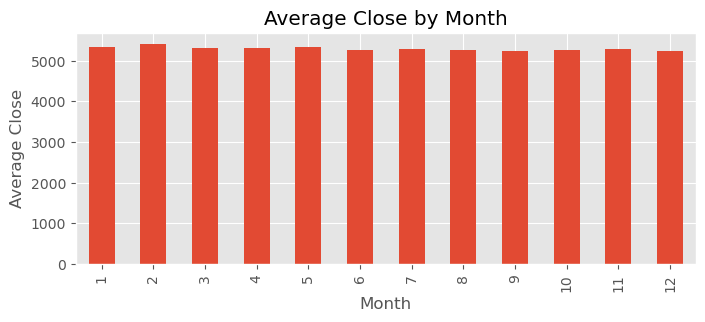

In [29]:
# Autocorrelation of returns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plt.figure(figsize=(10,4))
plot_acf(df['Return'].dropna(), lags=30)
plt.title('Autocorrelation of Returns (30 lags)')
plt.show()


# Partial ACF
plt.figure(figsize=(10,4))
plot_pacf(df['Return'].dropna(), lags=30, method='ywm')
plt.title('Partial Autocorrelation of Returns')
plt.show()


# Seasonality: monthly average close
df['month'] = df['date'].dt.month
monthly = df.groupby('month')['close'].mean()
plt.figure(figsize=(8,3))
monthly.plot(kind='bar')
plt.title('Average Close by Month')
plt.xlabel('Month')
plt.ylabel('Average Close')
plt.show()

RSI           0.168453
Return        0.109579
Volatility    0.107409
volume        0.087025
MA20          0.085872
MA50          0.082675
low           0.078575
open          0.075568
close         0.070167
high          0.068072
adjclose      0.066605
dtype: float64


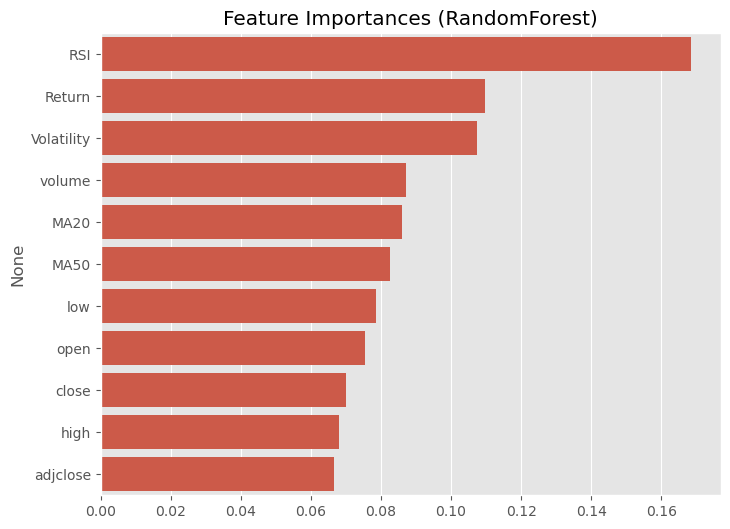

In [31]:
# Use a simple RandomForest to get feature importances (no heavy tuning, fast check)
from sklearn.ensemble import RandomForestClassifier


# Prepare numeric features and drop Target from X
X = numeric.drop(columns=['Target'], errors='ignore')
y = numeric['Target']


# Fit a small RF
rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X.fillna(0), y)


importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(20))


# Plot importances
plt.figure(figsize=(8,6))
sns.barplot(x=importances.values[:20], y=importances.index[:20])
plt.title('Feature Importances (RandomForest)')
plt.show()

Rule Confusion Matrix:
 [[ 797 1111]
 [ 896 1207]]
Rule Accuracy: 0.49962602842183995
Rule F1: 0.5460303098846415


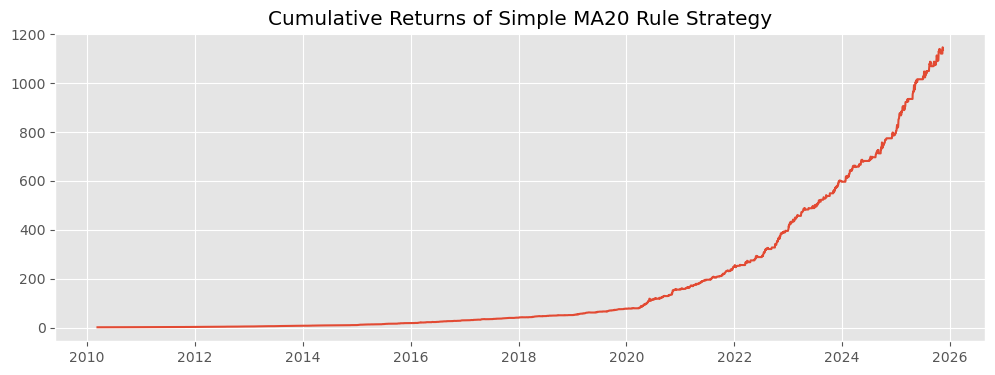

In [33]:
# Quick test: predict using a simple rule: close > MA20 -> predict UP, else DOWN
rule_pred = (df['close'] > df['MA20']).astype(int)


from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


cm = confusion_matrix(df['Target'], rule_pred)
print('Rule Confusion Matrix:\n', cm)
print('Rule Accuracy:', accuracy_score(df['Target'], rule_pred))
print('Rule F1:', f1_score(df['Target'], rule_pred))


# Simple cumulative returns if following predictions (long if predict UP, else 0)
df['strategy_returns'] = df['Return'] * rule_pred.shift(0) # apply today's prediction
cumulative = (1 + df['strategy_returns'].fillna(0)).cumprod()


plt.figure(figsize=(12,4))
plt.plot(df['date'], cumulative)
plt.title('Cumulative Returns of Simple MA20 Rule Strategy')
plt.show()

In [35]:
# Optionally save the cleaned DataFrame used for analysis
df.to_csv('data/cac40_analysis_snapshot.csv', index=False)
print('Saved snapshot file to data/cac40_analysis_snapshot.csv')

Saved snapshot file to data/cac40_analysis_snapshot.csv
